# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Если клиент отменяет бронирование, то компания терпит убытки. 
Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Бизнес-метрика - прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.  
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:  
категория A: за ночь — 1 000, разовое обслуживание — 400;  
категория B: за ночь — 800, разовое обслуживание — 350;  
категория C: за ночь — 600, разовое обслуживание — 350;  
категория D: за ночь — 550, разовое обслуживание — 150;  
категория E: за ночь — 500, разовое обслуживание — 150;  
категория F: за ночь — 450, разовое обслуживание — 150;  
категория G: за ночь — 350, разовое обслуживание — 150.  

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.  

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.  

На разработку системы прогнозирования заложен бюджет — 400 000.  
Внедрение модели должно окупиться за тестовый период.  
Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Описание данных  
В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:  
id — номер записи;  
adults — количество взрослых постояльцев;  
arrival_date_year — год заезда;  
arrival_date_month — месяц заезда;  
arrival_date_week_number — неделя заезда;  
arrival_date_day_of_month — день заезда;  
babies — количество младенцев;  
booking_changes — количество изменений параметров заказа;  
children — количество детей от 3 до 14 лет;  
country — гражданство постояльца;  
customer_type — тип заказчика:  
Contract — договор с юридическим лицом;  
Group — групповой заезд;  
Transient — не связано с договором или групповым заездом;  
Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.  
days_in_waiting_list — сколько дней заказ ожидал подтверждения;  
distribution_channel — канал дистрибуции заказа;  
is_canceled — отмена заказа;  
is_repeated_guest — признак того, что гость бронирует номер второй раз;  
lead_time — количество дней между датой бронирования и датой прибытия;  
meal — опции заказа:  
SC — нет дополнительных опций;  
BB — включён завтрак;  
HB — включён завтрак и обед;  
FB — включён завтрак, обед и ужин.  
previous_bookings_not_canceled — количество подтверждённых заказов у клиента;  
previous_cancellations — количество отменённых заказов у клиента;  
required_car_parking_spaces — необходимость места для автомобиля;  
reserved_room_type — тип забронированной комнаты;  
stays_in_weekend_nights — количество ночей в выходные дни;  
stays_in_week_nights — количество ночей в будние дни;  
total_nights — общее количество ночей;  
total_of_special_requests — количество специальных отметок.

## Шаг 1. Откроем файлы с данными

### Импортируем библиотеки

In [1]:
import pandas as pd
import os
import matplotlib as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder

### Введем константы

In [2]:
RANDOM = 12345
LIMIT = 400000

### Создадим таблицу стоимостей ночи и уборки номера

In [3]:
payments = pd.DataFrame(data={'night' : [1000, 800, 600, 550, 500, 450, 350],
                             'service' : [400, 350, 350, 150, 150, 150, 150], 
                             'reserved_room_type' : ['a', 'b', 'c', 'd', 'e', 'f', 'g']})

In [4]:
payments

,night,service,reserved_room_type
0,1000,400,a
1,800,350,b
2,600,350,c
3,550,150,d
4,500,150,e
5,450,150,f
6,350,150,g


### Добавим таблицу с сезонными коэффициентами

In [5]:
season_coefficient = pd.DataFrame(data={'coefficient' : [1.4, 1.4, 1.2, 1.2, 1.2, 1, 1, 
                                                         1, 1.2, 1.2, 1.2, 1.4], 
                                       'arrival_date_month' : ['July', 'August', 'September', 'October',
                                                  'November', 'December', 'January', 
                                                  'February', 'March', 'April', 'May', 
                                                  'June']})

In [6]:
season_coefficient

,coefficient,arrival_date_month
0,1.4,July
1,1.4,August
2,1.2,September
3,1.2,October
4,1.2,November
5,1.0,December
6,1.0,January
7,1.0,February
8,1.2,March
9,1.2,April


Загрузим данные

In [7]:
pth1 = 'datasets/hotel_train.csv'
pth2 = 'https://code.s3.yandex.net/datasets/hotel_train.csv'
    
if os.path.exists(pth1):
    hotel_train = pd.read_csv(pth1)
elif os.path.exists(pth2):
    hotel_train = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
pth3 = 'datasets/hotel_test.csv'
pth4 = 'https://code.s3.yandex.net/datasets/hotel_test.csv'
    
if os.path.exists(pth3):
    hotel_test = pd.read_csv(pth3)
elif os.path.exists(pth4):
    hotel_test = pd.read_csv(pth4)
else:
    print('Something is wrong')

## Шаг 2. Предобработка и исследовательский анализ данных

### Посмотрим информацию о данных

In [8]:
display(hotel_train.head())
print(hotel_train.info())
display(hotel_train.describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [9]:
display(hotel_test.head())
print(hotel_test.info())
display(hotel_test.describe())

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


### Удалим столбцы, не дающие дополнительной информации

In [10]:
hotel_train = hotel_train.drop(['id'], axis=1)
hotel_test = hotel_test.drop(['id'], axis=1)

In [11]:
hotel_train = hotel_train.drop(['stays_in_weekend_nights'], axis=1)
hotel_test = hotel_test.drop(['stays_in_weekend_nights'], axis=1)

hotel_train = hotel_train.drop(['stays_in_week_nights'], axis=1)
hotel_test = hotel_test.drop(['stays_in_week_nights'], axis=1)

### Проверим данные на наличие дубликатов

In [12]:
print('Количество дубликатов в обучающих данных', hotel_train.duplicated().sum())
print('доля от количества данных', hotel_train.duplicated().sum() / len(hotel_train))

Количество дубликатов в обучающих данных 21377
доля от количества данных 0.3277223320915544


In [13]:
print('Количество дубликатов в тестовых данных', hotel_test.duplicated().sum())
print('доля от количества данных', hotel_test.duplicated().sum() / len(hotel_test))

Количество дубликатов в тестовых данных 7717
доля от количества данных 0.23809083055658398


Избавимся от дубликатов

In [14]:
hotel_train = hotel_train.drop_duplicates()
hotel_test = hotel_test.drop_duplicates()

### Проверим данные на наличие пропусков

In [15]:
hotel_train.isna().sum()

is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

### Построим гистограммы признаков данных

array([[<AxesSubplot:title={'center':'is_canceled'}>,
        <AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'arrival_date_year'}>,
        <AxesSubplot:title={'center':'arrival_date_week_number'}>],
       [<AxesSubplot:title={'center':'arrival_date_day_of_month'}>,
        <AxesSubplot:title={'center':'adults'}>,
        <AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>],
       [<AxesSubplot:title={'center':'is_repeated_guest'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>,
        <AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>],
       [<AxesSubplot:title={'center':'days_in_waiting_list'}>,
        <AxesSubplot:title={'center':'required_car_parking_spaces'}>,
        <AxesSubplot:title={'center':'total_of_special_requests'}>,
        <AxesSubplot:title={'center':'total_nights'}>]], dtype=object)

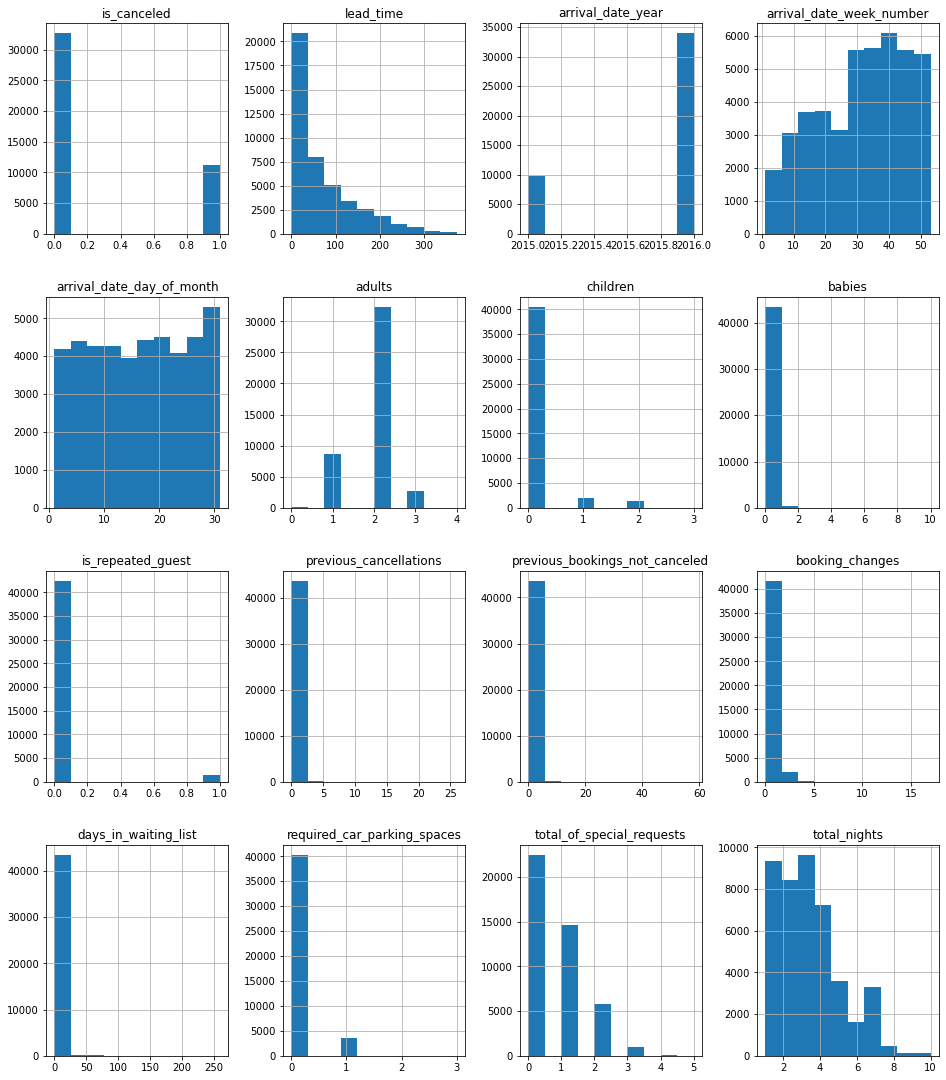

In [16]:
hotel_train.hist(figsize=[16,19])

Из гистограмм видно, что у нас наблюдается дисбаланс классов

In [17]:
hotel_train['is_canceled'].value_counts(normalize=True)

0    0.745781
1    0.254219
Name: is_canceled, dtype: float64

### Проверим категориальные признаки

In [18]:
hotel_train['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

Исправим обозначения типов комнат на маленькие буквы и избавимся от пробелов

In [19]:
hotel_train['reserved_room_type'] = hotel_train['reserved_room_type'].str.strip().str.lower()

In [20]:
hotel_test['reserved_room_type'] = hotel_test['reserved_room_type'].str.strip().str.lower()

In [21]:
hotel_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

In [22]:
hotel_train['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [23]:
hotel_train['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [24]:
hotel_train['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

Избавимся от лишних пробелов и поменяем на нижний регистр

In [25]:
hotel_train['meal'] = hotel_train['meal'].str.strip().str.lower()
hotel_test['meal'] = hotel_test['meal'].str.strip().str.lower()

### Проверим корреляцию данных

In [26]:
hotel_train.corr()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,1.000000,0.176093,0.057680,0.023653,0.017457,0.064218,0.041750,-0.016678,-0.056963,0.079904,-0.040576,-0.080964,0.002901,-0.174187,-0.134206,0.069679
lead_time,0.176093,1.000000,0.101006,0.103006,0.015908,0.138701,0.013070,-0.004663,-0.130339,0.037441,-0.065495,0.090533,0.162014,-0.074029,0.019557,0.340119
arrival_date_year,0.057680,0.101006,1.000000,-0.357274,-0.002564,0.052860,0.030153,-0.021724,0.021179,-0.061409,0.038590,0.010019,0.001735,-0.020028,0.009585,-0.039623
arrival_date_week_number,0.023653,0.103006,-0.357274,1.000000,0.088113,0.002772,-0.004985,0.006483,-0.016148,-0.009385,-0.009849,0.016730,-0.016469,-0.005282,0.098164,0.043014
arrival_date_day_of_month,0.017457,0.015908,-0.002564,0.088113,1.000000,0.010050,0.021420,-0.001225,-0.006166,-0.011110,-0.000020,0.017540,-0.002322,0.000845,-0.001914,-0.003048
adults,0.064218,0.138701,0.052860,0.002772,0.010050,1.000000,-0.015692,0.019339,-0.209945,-0.036539,-0.140665,-0.046174,-0.019280,0.005739,0.177508,0.165052
children,0.041750,0.013070,0.030153,-0.004985,0.021420,-0.015692,1.000000,0.011738,-0.037763,-0.017934,-0.023967,0.037511,-0.018070,0.026702,0.075297,0.012876
babies,-0.016678,-0.004663,-0.021724,0.006483,-0.001225,0.019339,0.011738,1.000000,-0.015375,-0.005181,-0.008704,0.075170,-0.007390,0.022959,0.095190,0.019770
is_repeated_guest,-0.056963,-0.130339,0.021179,-0.016148,-0.006166,-0.209945,-0.037763,-0.015375,1.000000,0.216689,0.462992,0.005788,-0.014493,0.059737,-0.046106,-0.138912
previous_cancellations,0.079904,0.037441,-0.061409,-0.009385,-0.011110,-0.036539,-0.017934,-0.005181,0.216689,1.000000,0.333962,-0.012963,0.005947,-0.009064,-0.016383,-0.017484


In [27]:
print(hotel_train.corrwith(hotel_train['is_canceled']))

is_canceled                       1.000000
lead_time                         0.176093
arrival_date_year                 0.057680
arrival_date_week_number          0.023653
arrival_date_day_of_month         0.017457
adults                            0.064218
children                          0.041750
babies                           -0.016678
is_repeated_guest                -0.056963
previous_cancellations            0.079904
previous_bookings_not_canceled   -0.040576
booking_changes                  -0.080964
days_in_waiting_list              0.002901
required_car_parking_spaces      -0.174187
total_of_special_requests        -0.134206
total_nights                      0.069679
dtype: float64


### Построим сводные таблицы по признакам

In [28]:
hotel_train.pivot_table(index=['lead_time'], 
                 values='is_canceled', 
                 aggfunc=['count', 'mean'])\
                    .style.format({('mean', 'is_canceled'): '{:.2%}'})

,count,mean
,is_canceled,is_canceled
lead_time,,
0.0,3110,5.72%
1.0,1770,7.12%
2.0,1057,9.08%
3.0,976,10.35%
4.0,896,10.71%
5.0,835,12.93%
6.0,723,12.86%
7.0,632,13.92%


In [29]:
for i in hotel_train.columns:
    if i in ['adults', 'arrival_date_month', 'babies', 'booking_changes', 'children', 'country',
             'customer_type', 'days_in_waiting_list', 'distribution_channel', 'is_repeated_guest', 
             'meal', 'previous_bookings_not_canceled', 'previous_cancellations',
             'required_car_parking_spaces', 'reserved_room_type', 'stays_in_weekend_nights',
             'stays_in_week_nights', 'total_nights', 'total_of_special_requests']:
        display(hotel_train.pivot_table(index=i, 
                                values='is_canceled',
                                aggfunc=['count', 'mean'])\
        .style.format({('mean', 'is_canceled'): '{:.2%}'}))

,count,mean
,is_canceled,is_canceled
arrival_date_month,,
April,3219,27.56%
August,4725,28.70%
December,4135,27.45%
February,2300,18.30%
January,1471,16.11%
July,4016,29.81%
June,2828,26.87%
March,3247,24.18%


,count,mean
,is_canceled,is_canceled
adults,,
0.0,164,29.27%
1.0,8688,19.30%
2.0,32299,26.73%
3.0,2688,29.32%
4.0,13,7.69%


,count,mean
,is_canceled,is_canceled
children,,
0.0,40471,24.99%
1.0,2060,27.28%
2.0,1305,35.86%
3.0,16,37.50%


,count,mean
,is_canceled,is_canceled
babies,,
0.0,43403,25.50%
1.0,444,18.24%
2.0,3,0.00%
9.0,1,0.00%
10.0,1,0.00%


,count,mean
,is_canceled,is_canceled
meal,,
bb,35552,24.54%
fb,135,30.37%
hb,3344,24.52%
sc,4821,32.40%


,count,mean
,is_canceled,is_canceled
country,,
ABW,1,0.00%
AGO,123,37.40%
ALB,6,16.67%
AND,1,100.00%
ARE,23,91.30%
ARG,98,19.39%
ARM,6,33.33%
ATA,1,0.00%


,count,mean
,is_canceled,is_canceled
distribution_channel,,
Corporate,2755,12.70%
Direct,5822,13.98%
GDS,90,18.89%
TA/TO,35185,28.33%


,count,mean
,is_canceled,is_canceled
is_repeated_guest,,
0,42408,25.88%
1,1444,11.98%


,count,mean
,is_canceled,is_canceled
previous_cancellations,,
0,42701,23.98%
1,995,86.43%
2,52,40.38%
3,47,25.53%
4,5,20.00%
5,13,15.38%
6,2,100.00%
11,27,7.41%


,count,mean
,is_canceled,is_canceled
previous_bookings_not_canceled,,
0,42368,26.12%
1,598,4.35%
2,251,5.18%
3,134,6.72%
4,113,7.08%
5,89,7.87%
6,55,3.64%
7,34,0.00%


,count,mean
,is_canceled,is_canceled
reserved_room_type,,
a,30445,24.49%
b,745,29.66%
c,227,18.94%
d,8423,28.59%
e,2254,22.32%
f,1178,28.61%
g,580,31.03%


,count,mean
,is_canceled,is_canceled
booking_changes,,
0,36265,27.69%
1,5391,13.32%
2,1578,17.43%
3,379,15.04%
4,138,21.74%
5,41,24.39%
6,18,38.89%
7,18,11.11%


,count,mean
,is_canceled,is_canceled
days_in_waiting_list,,
0,43372,25.36%
1,3,0.00%
2,2,0.00%
3,2,100.00%
4,10,10.00%
5,2,50.00%
6,4,0.00%
8,4,100.00%


,count,mean
,is_canceled,is_canceled
customer_type,,
Contract,1874,19.74%
Group,259,7.34%
Transient,35369,27.34%
Transient-Party,6350,17.15%


,count,mean
,is_canceled,is_canceled
required_car_parking_spaces,,
0,40253,27.69%
1,3587,0.00%
2,11,0.00%
3,1,0.00%


,count,mean
,is_canceled,is_canceled
total_of_special_requests,,
0,22429,31.99%
1,14598,18.69%
2,5775,18.29%
3,940,19.04%
4,100,11.00%
5,10,0.00%


,count,mean
,is_canceled,is_canceled
total_nights,,
1,9359,18.11%
2,8442,25.87%
3,9632,27.52%
4,7216,27.59%
5,3599,26.92%
6,1609,32.07%
7,3280,27.74%
8,477,32.29%


### Проверим наличие выбросов и аномалий

Проверим количество броней без взрослых

In [30]:
hotel_train.loc[hotel_train['adults'] == 0]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
17540,0,1.0,2015,August,33,10,0.0,3.0,0.0,bb,...,0,0,0,b,1,0,Transient-Party,0,0,2
17598,0,104.0,2015,August,33,11,0.0,2.0,0.0,bb,...,0,0,0,b,1,0,Transient-Party,0,2,3
17982,0,3.0,2015,August,34,16,0.0,2.0,0.0,bb,...,0,0,0,b,1,0,Transient-Party,0,1,2
21556,1,48.0,2015,October,43,19,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient-Party,0,1,4
22516,1,6.0,2015,December,51,13,0.0,3.0,0.0,bb,...,0,0,0,b,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64751,0,197.0,2016,December,52,21,0.0,3.0,0.0,hb,...,0,0,0,a,7,0,Transient-Party,0,0,5
64882,0,104.0,2016,December,53,25,0.0,2.0,0.0,bb,...,0,0,0,b,1,0,Transient,0,2,3
64892,0,104.0,2016,December,53,25,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,2,3
64903,0,247.0,2016,December,52,24,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,1,5


In [31]:
hotel_test.loc[hotel_test['adults'] == 0]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
7743,1,111.0,2017,January,1,2,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,2,4
7751,1,268.0,2017,January,1,2,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,1,5
8772,1,148.0,2017,February,6,5,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,2,7
9243,1,134.0,2017,February,8,22,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,1,6
9305,1,148.0,2017,February,8,24,0.0,2.0,0.0,bb,...,0,0,0,b,1,0,Transient,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30601,0,296.0,2017,July,30,27,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,1,4
30654,0,276.0,2017,July,31,30,0.0,2.0,0.0,bb,...,0,0,0,b,1,0,Transient,0,2,3
30678,0,291.0,2017,July,30,29,0.0,2.0,0.0,bb,...,0,0,0,b,0,0,Transient,0,1,4
30815,0,159.0,2017,July,31,31,0.0,2.0,0.0,sc,...,0,0,0,a,1,0,Transient,0,1,4


Избавимся от этих строк, так как должен быть хотя бы один взрослый клиент в номере

In [32]:
hotel_train = hotel_train.loc[hotel_train['adults'] != 0]
hotel_test = hotel_test.loc[hotel_test['adults'] != 0]

Проверим наличие выбросов

In [33]:
hotel_train.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000,43688.000000
mean,0.254074,67.793948,2015.774973,31.094626,15.914576,1.863258,0.101035,0.010667,0.033030,0.041773,0.155306,0.248466,0.824437,0.082631,0.669932,3.207311
std,0.435345,73.968086,0.417605,13.891084,8.859681,0.492838,0.381192,0.119994,0.178716,0.460164,1.586831,0.678028,9.920652,0.276489,0.802496,1.878039
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,9.000000,2016.000000,20.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,41.000000,2016.000000,33.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1.000000,102.000000,2016.000000,43.000000,24.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Построим гистограмму распределения количества дней между датой бронирования и датой прибытия

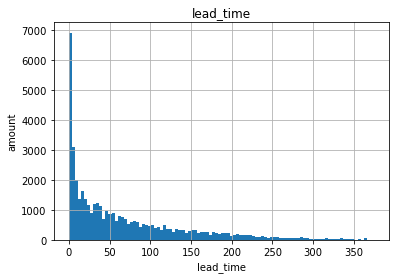

In [34]:
ax = hotel_train.hist(column='lead_time', bins=100, range=(0,374))
ax = ax[0]
for x in ax:
    x.set_xlabel("lead_time")
    x.set_ylabel("amount")

Избавимся от значений больше (Q3 + 1.5 * IQR) - будем считать эти данные выбросами

In [35]:
hotel_train = hotel_train.loc[hotel_train['lead_time'] <= hotel_train['lead_time'].quantile(0.75) + 
                              1.5 * (hotel_train['lead_time'].quantile(0.75) - 
                                     hotel_train['lead_time'].quantile(0.25))]

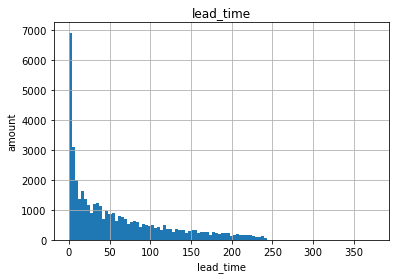

In [36]:
ax = hotel_train.hist(column='lead_time', bins=100, range=(0,374))
ax = ax[0]
for x in ax:
    x.set_xlabel("lead_time")
    x.set_ylabel("amount")

Посмотрим данные о количестве младенцев

In [37]:
hotel_train['babies'].value_counts()

0.0     41646
1.0       430
2.0         3
9.0         1
10.0        1
Name: babies, dtype: int64

9 и 10 явно выбросы, их всего по одной штуке, избавимся от этих строк

In [38]:
hotel_train = hotel_train.loc[hotel_train['babies'] < 9]

Посмотрим данные о количестве дней ожидания подтверждения

In [39]:
hotel_train['days_in_waiting_list'].describe()

count    42079.000000
mean         0.443808
std          5.717648
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        167.000000
Name: days_in_waiting_list, dtype: float64

Избавимся от значений больше (Q3 + 1.5 * IQR) - будем считать эти данные выбросами

In [40]:
hotel_train = hotel_train.loc[hotel_train['days_in_waiting_list'] <= hotel_train['days_in_waiting_list'].quantile(0.75) + 
                              1.5 * (hotel_train['days_in_waiting_list'].quantile(0.75) - 
                                     hotel_train['days_in_waiting_list'].quantile(0.25))]

### Вывод:  

В данных наблюдается дисбаланс классов, поэтому при построении модели будет необходимо это учесть. 

В результате исследовательского анализа можно отметить следующие наблюдения:  
- по количеству дней между датой бронирования и заселения не наблюдается сильной взаимосвязи с вероятностью отмены брони, можно отметить, что если человек бронирует в день заезда, то в большинстве случаев он не отменяет бронь;  
- по месяцу заезда тоже нет взаимосвязи с вероятностью отмены бронирования, реже всего отменяют бронирования на январь, что скорее всего связано с тем, что новогодние планы клиенты стоят заранее и редко меняют эти планы;  
- по количеству взрослых чаще всего отменяют бронь клиенты, которые бронировали на двух взрослых (скорее всего парам не сложно найти другое жилье или поменять свои планы), реже других отменяют бронь клиенты, которые бронировали на 4 взрослых (так как задействовано больше взрослых, то сложнее менять планы), однако таких клиентов всего 13 в нашем тренировочном наборе данных и, возможно, при увеличении числа таких клиентов вероятность поменяется;  
- по количеству детей зависимости с отменой брони не наблюдается, но реже других отменяют клиенты с одним ребенком (28,6%);  
- по количеству младенцев - у большинства клиентов (64777 из 65999) гостиницы нет младенцев, 37% из них отменяет бронь;  
- по питанию - чаще других (68.9%) отменяют бронь клиенты заказавшие завтрак, обед и ужин;  
- по странам - из тех стран, откуда достаточно много клиентов можно обратить внимание на то, что редко отменяют бронь жители Германии (DEU) 13.9%, Франции (FRA) 14.66%, Великобритании (GBR) 18.3%, часто отменяют жители Италии (ITA) 32.9% и Португалии (PRT) 57.5%, скорее всего это связано с особенностями культуры стран с южным климатом;  
- по каналу продаж - больше всего продаж совершается через туристические агенства (TA/TO), но при этом 40.4% из них отменятеся, клиенты, бронирующие самостоятельно, отказываются от брони в 17.3% случаев;  
- "старый" клиент - большинство клиентов бронируют номер впервые, 37.1% отказывается от брони;  
- предыдущие отмены бронирования - большинство клиентов ранее не отменяли бронирования, из них 32.2% отменяют свою бронь, при этом если клиент ранее отменял свою бронь 1 раз, то высока вероятность, что он снова отменит бронь - 97.4%;  
- количество подтвержденных заказов - если клиент ранее подтверждал заказ, то наиболее вероятно, что он не отменит бронь, но при этом большинство клинтов не подтверждало бронирование раньше (63686 клиентов);  
- по категорию комнаты - чаще всего отменяют бронь клиенты, бронировавшие комнаты категории А - 39%;  
- по количеству изменений брони - большинство клиентов не изменяют бронь, но если внесли хотя бы одно изменение, то более вероятно, что отмены брони не будет;  
- по брони парковочных мест - большинство клиентов не запрашивают парковочных мест, но если запросили хотя бы одно место, то вероятнее всего отмены бронирования не произойдет (в тренировочных данных - 100%);  
- по количеству специальных запросов - если у клиента есть специальные запросы, то скорее всего бронь не будет отменена - меньше 19.59%;  
- по количеству заброннированных ночей - реже других отменяют бронь клиенты, которые забронировали только одну ночь (25.5%), чаще других отменяют бронь клинты, забронировавшие две ночи (45.1%)

## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Оценим прибыль отеля без внедрения депозитов. 

Так как в задании не уточнено сколько ночей считается длительным пребыванием (не известен порог, в каком случае убираются раз в два дня), то за порог возьмем 7 ночей.

### Создадим функцию, котороя добавляет столбцы с указанием сезонного коэффициента,  стоимости одной ночи и стоимости одной уборки в номере

In [41]:
def new_columns(df):
    df = df.merge(season_coefficient) #добавим столбец с указанием сезонного коэффициента
    df = df.merge(payments, on='reserved_room_type') #добавим столбцы с указанием стоимости одной ночи и 
    #стоимости уборки номера
   
    return df  

### Создадим функцию, добавляющую столбец с прибылью для каждого id.  
Сумма прибыли равна:  
- коэффициент_сезона * (количество_ночей * стоимость_одной_ночи - стоимость_уборки * (1 + количество_ночей // 2)), в случае, если не было отмены брони
- коэффициент_сезона * (стоимость_одной_ночи + стоимость_уборки)

In [42]:
def profit(df):
    df['profit'] = np.where(df['is_canceled'] == 0, #условие - отменен ли заказ
                                df['coefficient'] * (df['total_nights'] * df['night'] - df['service'] * 
                                                     (1 + df['total_nights'] // 2)),
                                - df['coefficient'] * (df['night'] + df['service']))

### Применим эти функциии к обучаещему набору данных

In [43]:
hotel_train = new_columns(hotel_train)
profit(hotel_train)
display(hotel_train.head())
print(hotel_train.info())
display(hotel_train.describe())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,night,service,profit
0,0,7.0,2015,July,27,1,1.0,0.0,0.0,bb,...,0,0,Transient,0,0,1,1.4,1000,400,840.0
1,0,14.0,2015,July,27,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,1,2,1.4,1000,400,1680.0
2,1,85.0,2015,July,27,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,1,3,1.4,1000,400,-1960.0
3,0,0.0,2015,July,27,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,0,1,1.4,1000,400,840.0
4,0,72.0,2015,July,27,1,2.0,0.0,0.0,bb,...,1,0,Transient,0,1,6,1.4,1000,400,6160.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 41735 entries, 0 to 41734
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     41735 non-null  int64  
 1   lead_time                       41735 non-null  float64
 2   arrival_date_year               41735 non-null  int64  
 3   arrival_date_month              41735 non-null  object 
 4   arrival_date_week_number        41735 non-null  int64  
 5   arrival_date_day_of_month       41735 non-null  int64  
 6   adults                          41735 non-null  float64
 7   children                        41735 non-null  float64
 8   babies                          41735 non-null  float64
 9   meal                            41735 non-null  object 
 10  country                         41735 non-null  object 
 11  distribution_channel            41735 non-null  object 
 12  is_repeated_guest               

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,night,service,profit
count,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000,41735.00000,41735.000000,41735.000000,41735.0,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000,41735.000000
mean,0.246891,58.935642,2015.775896,30.895172,15.887097,1.864981,0.103438,0.010447,0.033976,0.03412,0.159315,0.237978,0.0,0.084725,0.679741,3.175943,1.216648,856.415479,326.432251,1384.817300
std,0.431208,60.841156,0.416996,13.957392,8.879669,0.494038,0.385325,0.102380,0.181170,0.38703,1.609338,0.666199,0.0,0.279592,0.803193,1.865339,0.132578,218.615647,113.109926,2172.669386
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,350.000000,150.000000,-1960.000000
25%,0.000000,8.000000,2016.000000,19.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,1.200000,550.000000,150.000000,300.000000
50%,0.000000,38.000000,2016.000000,33.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,3.000000,1.200000,1000.000000,400.000000,1350.000000
75%,0.000000,92.000000,2016.000000,43.000000,24.000000,2.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,1.000000,4.000000,1.400000,1000.000000,400.000000,2640.000000
max,1.000000,241.000000,2016.000000,53.000000,31.000000,4.000000,3.000000,2.000000,1.000000,25.00000,58.000000,17.000000,0.0,3.000000,5.000000,10.000000,1.400000,1000.000000,400.000000,10640.000000


### Применим эти функции к тестовому набору данных

In [44]:
hotel_test = new_columns(hotel_test)
profit(hotel_test)
display(hotel_test.head())
print(hotel_test.info())
display(hotel_test.describe())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,night,service,profit
0,1,74.0,2017,January,1,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,0,1,1.0,1000,400,-1400.0
1,1,62.0,2017,January,1,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,1,4,1.0,1000,400,-1400.0
2,1,71.0,2017,January,1,1,1.0,0.0,0.0,bb,...,0,0,Transient,0,1,4,1.0,1000,400,-1400.0
3,1,172.0,2017,January,1,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,0,7,1.0,1000,400,-1400.0
4,1,52.0,2017,January,1,1,1.0,0.0,0.0,bb,...,0,0,Transient,0,0,7,1.0,1000,400,-1400.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24630 entries, 0 to 24629
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     24630 non-null  int64  
 1   lead_time                       24630 non-null  float64
 2   arrival_date_year               24630 non-null  int64  
 3   arrival_date_month              24630 non-null  object 
 4   arrival_date_week_number        24630 non-null  int64  
 5   arrival_date_day_of_month       24630 non-null  int64  
 6   adults                          24630 non-null  float64
 7   children                        24630 non-null  float64
 8   babies                          24630 non-null  float64
 9   meal                            24630 non-null  object 
 10  country                         24630 non-null  object 
 11  distribution_channel            24630 non-null  object 
 12  is_repeated_guest               

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,night,service,profit
count,24630.000000,24630.000000,24630.0,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000,24630.000000
mean,0.314941,88.584815,2017.0,18.194235,15.580390,1.892245,0.101624,0.007227,0.040560,0.015104,0.223711,0.253634,0.342387,0.059643,0.762241,3.287779,1.233268,848.313033,321.400731,1184.345920
std,0.464502,85.326076,0.0,9.438645,8.776494,0.486616,0.373763,0.086602,0.197273,0.206514,2.146085,0.697569,5.411589,0.247722,0.860804,1.818115,0.148955,221.087473,115.513649,2266.153604
min,0.000000,0.000000,2017.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,350.000000,150.000000,-1960.000000
25%,0.000000,16.000000,2017.0,10.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.200000,550.000000,150.000000,-840.000000
50%,0.000000,62.000000,2017.0,18.000000,15.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.200000,1000.000000,400.000000,1140.000000
75%,1.000000,143.000000,2017.0,26.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,1.400000,1000.000000,400.000000,2640.000000
max,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000,1.400000,1000.000000,400.000000,10640.000000


### Посчитаем суммарный доход для тестового набора данных

In [45]:
profit_test = hotel_test['profit'].sum()
print('Прибыль на тестовых данных составила', f'{profit_test:,.2f}')

Прибыль на тестовых данных составила 29,170,440.00


## Шаг 4. Разработка модели ML

### Преобразуем данные с методом OHE

In [46]:
hotel_train_ohe = pd.get_dummies(hotel_train, drop_first=True)
hotel_train_ohe.head()
hotel_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41735 entries, 0 to 41734
Columns: 199 entries, is_canceled to customer_type_Transient-Party
dtypes: float64(6), int64(14), uint8(179)
memory usage: 13.8 MB


In [47]:
hotel_test_ohe = pd.get_dummies(hotel_test, drop_first=True)
hotel_test_ohe.head()
hotel_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24630 entries, 0 to 24629
Columns: 184 entries, is_canceled to customer_type_Transient-Party
dtypes: float64(6), int64(14), uint8(164)
memory usage: 7.8 MB


In [48]:
hotel_test = hotel_test.merge(hotel_train, how='left')
hotel_train = hotel_train.merge(hotel_test, how='left')
print(hotel_test.info())
print(hotel_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24630 entries, 0 to 24629
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     24630 non-null  int64  
 1   lead_time                       24630 non-null  float64
 2   arrival_date_year               24630 non-null  int64  
 3   arrival_date_month              24630 non-null  object 
 4   arrival_date_week_number        24630 non-null  int64  
 5   arrival_date_day_of_month       24630 non-null  int64  
 6   adults                          24630 non-null  float64
 7   children                        24630 non-null  float64
 8   babies                          24630 non-null  float64
 9   meal                            24630 non-null  object 
 10  country                         24630 non-null  object 
 11  distribution_channel            24630 non-null  object 
 12  is_repeated_guest               

In [49]:
hotel_test = hotel_test.fillna(0)
hotel_train = hotel_train.fillna(0)

### Преобразуем данные методом OE

In [50]:
hotel_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,babies,meal,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,night,service,profit
0,0,7.0,2015,July,27,1,1.0,0.0,0.0,bb,...,0,0,Transient,0,0,1,1.4,1000,400,840.0
1,0,14.0,2015,July,27,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,1,2,1.4,1000,400,1680.0
2,1,85.0,2015,July,27,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,1,3,1.4,1000,400,-1960.0
3,0,0.0,2015,July,27,1,2.0,0.0,0.0,bb,...,0,0,Transient,0,0,1,1.4,1000,400,840.0
4,0,72.0,2015,July,27,1,2.0,0.0,0.0,bb,...,1,0,Transient,0,1,6,1.4,1000,400,6160.0


In [51]:
encoder = OrdinalEncoder()
hotel_train_ordinal = hotel_train
hotel_train_ordinal[['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 
                    'customer_type']] = encoder.fit_transform(
    hotel_train[['arrival_date_month','meal', 'country', 'distribution_channel', 'reserved_room_type',
                'customer_type']])

In [52]:
hotel_train_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41735 entries, 0 to 41734
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     41735 non-null  int64  
 1   lead_time                       41735 non-null  float64
 2   arrival_date_year               41735 non-null  int64  
 3   arrival_date_month              41735 non-null  float64
 4   arrival_date_week_number        41735 non-null  int64  
 5   arrival_date_day_of_month       41735 non-null  int64  
 6   adults                          41735 non-null  float64
 7   children                        41735 non-null  float64
 8   babies                          41735 non-null  float64
 9   meal                            41735 non-null  float64
 10  country                         41735 non-null  float64
 11  distribution_channel            41735 non-null  float64
 12  is_repeated_guest               

In [53]:
encoder = OrdinalEncoder()
hotel_test_ordinal = hotel_test
hotel_test_ordinal[['arrival_date_month', 'meal', 'country', 'distribution_channel', 'reserved_room_type', 
                    'customer_type']] = encoder.fit_transform(
    hotel_test[['arrival_date_month','meal', 'country', 'distribution_channel', 'reserved_room_type',
                'customer_type']])
hotel_train_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41735 entries, 0 to 41734
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     41735 non-null  int64  
 1   lead_time                       41735 non-null  float64
 2   arrival_date_year               41735 non-null  int64  
 3   arrival_date_month              41735 non-null  float64
 4   arrival_date_week_number        41735 non-null  int64  
 5   arrival_date_day_of_month       41735 non-null  int64  
 6   adults                          41735 non-null  float64
 7   children                        41735 non-null  float64
 8   babies                          41735 non-null  float64
 9   meal                            41735 non-null  float64
 10  country                         41735 non-null  float64
 11  distribution_channel            41735 non-null  float64
 12  is_repeated_guest               

### Разделим данные на признаки и целевой признак

In [54]:
features_train_ohe = hotel_train_ohe.drop(['is_canceled', 'profit'], axis=1)
target_train_ohe = hotel_train_ohe['is_canceled']
features_test_ohe = hotel_test_ohe.drop(['is_canceled', 'profit'], axis=1)
target_test_ohe = hotel_test_ohe['is_canceled']

In [55]:
features_train_ohe.info()
features_test_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41735 entries, 0 to 41734
Columns: 197 entries, lead_time to customer_type_Transient-Party
dtypes: float64(5), int64(13), uint8(179)
memory usage: 13.2 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24630 entries, 0 to 24629
Columns: 182 entries, lead_time to customer_type_Transient-Party
dtypes: float64(5), int64(13), uint8(164)
memory usage: 7.4 MB


In [56]:
features_train_ordinal = hotel_train_ordinal.drop(['is_canceled', 'profit'], axis=1)
target_train_ordinal = hotel_train_ordinal['is_canceled']
features_test_ordinal = hotel_test_ordinal.drop(['is_canceled', 'profit'], axis=1)
target_test_ordinal = hotel_test_ordinal['is_canceled']
features_train_ordinal.info()
features_test_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41735 entries, 0 to 41734
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       41735 non-null  float64
 1   arrival_date_year               41735 non-null  int64  
 2   arrival_date_month              41735 non-null  float64
 3   arrival_date_week_number        41735 non-null  int64  
 4   arrival_date_day_of_month       41735 non-null  int64  
 5   adults                          41735 non-null  float64
 6   children                        41735 non-null  float64
 7   babies                          41735 non-null  float64
 8   meal                            41735 non-null  float64
 9   country                         41735 non-null  float64
 10  distribution_channel            41735 non-null  float64
 11  is_repeated_guest               41735 non-null  int64  
 12  previous_cancellations          

**Так как перед нами стоит задача бинарной классификации, то обучим три модели:**  
- Решающее дерево
- Случайный лес
- Логистическая регрессия  

**Качество моделей будем определять кросс-валидацией, которая встроена в RandomizedSearchCV и GridSearchCV** 

**Метрику качества выберем f1-score**

Так как переда нами задача классификации, то в качестве метрики качества мы можем выбрать accuracy, precision, recall или f1-score. 

Из-за дисбаланса классов accuracy нам не подойдет, так как может начать обучиться выбирать класс тот, который больше представлен вы выборке,  

если в качестве метрики выбрать precision, то мы можем получить классификатор, который будет выдаст много ложноположительных результатов, что для нас означает - мы не сможем предсказать, когда клиент откажется от брони;  

если в качестве метрики выбрать recall, то мы максимизируем количество предсказанных отказов, что в рамказ ML задачи звучит хорошо, но это может создать неудобства для остальных клиентов, которые составляют большую часть (60%), так как модель будет чаще предсказывать более высокую вероятность отказа этим клиентам и им придется вносить предоплату, что может побудить отказаться от бронирования в этой гостинице;  

по этим причинам в качестве метрики качества выбрана f1-score

### Решающее дерево

Определим область лучших решений с помощью RandomizedSearchCV, для борьбы с дисбалансом будем использовать взвешивание классов

In [57]:
%%time
clf = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM)
parametrs = {'max_depth' : range(1, 50),
            'min_samples_split' : range(2, 20),
            'min_samples_leaf' : range(1, 20)}
rand = RandomizedSearchCV(clf, parametrs, scoring='f1',random_state=RANDOM)
rand.fit(features_train_ordinal, target_train_ordinal)
print('best_score_f1 =', rand.best_score_)
print('best params', rand.best_params_)

best_score_f1 = 0.5699423786895664
best params {'min_samples_split': 19, 'min_samples_leaf': 7, 'max_depth': 7}
CPU times: user 13.6 s, sys: 609 ms, total: 14.2 s
Wall time: 18.3 s


Теперь подберем лучшие параметры с помощью GridSearchCV

In [58]:
%%time
clf = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM)
parametrs = {'max_depth' : range(4, 10),
            'min_samples_split' : range(16, 22),
            'min_samples_leaf' : range(4, 10)}
grid = GridSearchCV(clf, parametrs, scoring='f1')
grid.fit(features_train_ordinal, target_train_ordinal)
print('best_score_train =', grid.best_score_)
print('best params', grid.best_params_)

best_score_train = 0.5706813208094396
best params {'max_depth': 7, 'min_samples_leaf': 9, 'min_samples_split': 16}
CPU times: user 2min 6s, sys: 8.94 s, total: 2min 15s
Wall time: 2min 28s


Лучший результат получился  
**f1_score = 0.57068**  
при параметрах:  
max_depth = 7,  
min_samples_leaf = 9,  
min_samples_split = 16

### Случайный лес

Определим область лучших решений с помощью RandomizedSearchCV, для борьбы с дисбалансом будем использовать взвешивание классов

In [59]:
%%time
clf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM)
parametrs = {'n_estimators' : [60],
                 'max_depth' : range(1, 50),
                 'min_samples_split' : range(2, 20),
                 'min_samples_leaf' : range(1, 20)}
rand = RandomizedSearchCV(clf, parametrs, scoring='f1',random_state=RANDOM)
rand.fit(features_train_ordinal, target_train_ordinal)
print('best_score_train =', rand.best_score_)
print('best params', rand.best_params_)

best_score_train = 0.5625442506526589
best params {'n_estimators': 60, 'min_samples_split': 19, 'min_samples_leaf': 7, 'max_depth': 7}
CPU times: user 1min 25s, sys: 2.48 s, total: 1min 28s
Wall time: 1min 32s


Теперь увеличим количество решающих деревьев

In [60]:
%%time
clf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM)
parametrs = {'n_estimators' : [150], 
                 'max_depth' : [7],
                 'min_samples_split' : range(17, 21),
                 'min_samples_leaf' : range(5, 9)}
grid = GridSearchCV(clf, parametrs, scoring='f1')
grid.fit(features_train_ordinal, target_train_ordinal)
print('best_score_train =', grid.best_score_)
print('best params', grid.best_params_)

best_score_train = 0.5612467084175188
best params {'max_depth': 7, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 150}
CPU times: user 3min 31s, sys: 6.05 s, total: 3min 37s
Wall time: 3min 46s


Лучший результат получился  
**f1_score = 0.56254**  
при параметрах:  
n_estimators = 60,  
max_depth = 7,  
min_samples_leaf = 7,  
min_samples_split = 19

### Логистическая регрессия

In [ ]:
%%time
clf = LogisticRegression(class_weight='balanced', random_state=RANDOM)
parametrs = {'penalty': ['l2'],
             'C': [0.001,0.01,0.1,1],
             'solver': ['newton-cg']}
grid = GridSearchCV(clf, parametrs, scoring='f1')
grid.fit(features_train_ohe, target_train_ohe)
print('best_score_train =', grid.best_score_)
print('best params', grid.best_params_)

/Users/antonina/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/antonina/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/antonina/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/antonina/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/antonina/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: Line

Лучший результат получился  
**f1_score = 0.49113**  
при параметрах:  
C = 0.1,  
penalty = l2,  
solver = newton-cg

### Проверим лучшую модель на тестовых данных 

In [ ]:
clf = DecisionTreeClassifier(class_weight='balanced', max_depth = 7, min_samples_leaf = 9,
                             min_samples_split = 16, random_state=RANDOM)
clf.fit(features_train_ordinal, target_train_ordinal)
predicted_test = clf.predict(features_test_ordinal)
print('f1_score =', f1_score(target_test_ordinal, predicted_test))

### Посчитаем прибыль от внедрения модели

Добавим столбец с предсказанными значениями

In [ ]:
hotel_test['predicted'] = predicted_test

Добавим столбец с прибыль с каждого id в тестовых данных

In [ ]:
hotel_test['profit_pred'] = np.where(hotel_test['is_canceled'] == 0, #условие - отменен ли заказ
                                     hotel_test['coefficient'] * (hotel_test['total_nights'] * 
                                                                  hotel_test['night'] - hotel_test['service'] * 
                                                                  (1 + hotel_test['total_nights'] // 
                                                                   2)),
                                     np.where(hotel_test['predicted'] == 0,
                                              - hotel_test['coefficient'] * (hotel_test['night'] + 
                                                                             hotel_test['service']),
                                             0.2 * (- hotel_test['coefficient'] * 
                                                    (hotel_test['night'] + hotel_test['service']))))

Посчитаем суммарную прибыль и сравним её с тратами на разработку системы

In [ ]:
profit_with_system = hotel_test['profit_pred'].sum()
print('Суммарная прибыль с внедренной системой составляет за тестовый период', f'{profit_with_system:,.2f}')
print('что на', f'{(profit_with_system - profit_test - LIMIT):,.2f}', 'больше прибыли без внедренной системы с учётом стоимость разработки системы')

## Шаг 5. Опишем портрет «ненадёжного» клиента

Портрет "ненадежного" клиента:  
бронирует номер на июль для двоих взрослых, без детей, на две ночи с питанием - завтрак, обед и ужин, бронь совершает через туристическое агенство, ранее не проживал в этой гостинице, при этом ранее отменял бронирование в этой гостинице, бронирует номер категории А, не вносит изменение в бронирование, не запрашивает место для парковки, не делает дополнительных специальных запросов

## Шаг 6. Общий вывод

Целью исследования было создание модели, определяющей вероятность отказа клиента от брони номера в сети отелей "Как в гостях".  

Требовалось, чтобы увеличение прибыли от внедрения системы покрыло стоимость разработки в первый год её использования.  

В результате была разработана модель, которая на тестовых данных показала f1_score = .  
Прибыль показанная на тестовых данных составила - , что на превышает сумму прибыли сети отелей без системы и расходов на разработку системы, что соостветсвует требованиям к модели.  

В качестве модели была выбрана модель решающего дерева, так как на ней удалось добиться наилучших результатов на тренировочных данных.  

Рекомендую внедрить систему, так как из-за большого количества отказов бронирования (36.8%) сеть отелей несет большие убытки, благодаря системе можно значительно увеличить прибыль.